In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

from tqdm import tqdm

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, GaussianNoise

from minefield import Minefield

To make the model flexible across input sizes, we use a fully convolutional network. While we could simply copy over the filter weights and train new dense layers afterwards, this architecture is fully agnostic to input size. Downside is that spatial dependency is a bit more limited. Model is estimating values in parallel

In [2]:
def make_model(env_shape, filters, sizes):
    inputs = keras.Input(shape = env_shape)
    print(inputs.shape)

    conv1 = Conv2D(filters[0], sizes[0], padding = 'same', activation = 'relu', input_shape = env_shape, data_format = 'channels_last')(inputs)
    conv1 = Conv2D(filters[0], sizes[0], padding = 'same', activation = 'relu')(conv1)
    conv1 = GaussianNoise(0.2)(conv1)
    print(conv1.shape)
    conv2 = Conv2D(filters[1], sizes[1],  padding = 'same', activation = 'relu')(conv1)
    conv2 = GaussianNoise(0.2)(conv2)
    print(conv2.shape)

    conv3 = Conv2D(filters[2], sizes[2], padding = 'same', activation = 'relu')(conv2)
    conv3 = GaussianNoise(0.2)(conv3)

    conv4 = Conv2D(3, 1, padding = 'same', activation = 'relu')(conv3)
    output = Conv2D(1, 3, padding = 'same', activation = lambda x: tf.nn.leaky_relu(x, alpha=0.1))(conv4)
    print(output.shape)

    model = keras.Model(inputs = inputs, outputs = output)
    model.compile('adam', loss='mse')
    print('Model Made')
    
    return model

rewards = {'safe_reward' : 15, 
          'repeat_loss' : -5, 
          'mine_loss' : -10, 
          'completion_reward' : 30}
env = Minefield(8, 8, 10, **rewards)

filters = [10, 8, 5]
sizes = [5, 5, 5]
env_shape = (8, 8, 11)

model = make_model(env_shape, filters, sizes)

(None, 8, 8, 11)
(None, 8, 8, 10)
(None, 8, 8, 8)
(None, 8, 8, 1)
Model Made


Need to estimate the Q value of each location, then correct the q value for the location that is chosen. Might be able to make it work where Q values for each individual location are calculated, which would be cool. 
SARSA: State -> action -> reward, state -> action

We are given a state as an input, plus an action taken in that state. We know the reward we got and what we currently value the state at (model.predict(state)). Therefore, we are able to update the value estimate at the index of the action taken based on known outcomes. Environment is highly deterministic, so we may actually be able to update all possible estimates. 

Doing this would involve having the model save a reward matrix, which indicates reward for clicking at each spot. Only exceptions would be if a click would create a game-ending scenario, in which case those clicks must be assigned the maximum reward. 

If game-ending, store all indices of block. Ending clicks are guaranteed to be unique. 
Other case to handle is algorithm stalling, not sure how to handle this except make winning reward greater than losing reward. 

In [3]:
def train_actual(model, hist, gamma, num_samps = 100, fin = False):
    '''In this training formulation, we use the "intrinsic value" property of the environment to get the targets. 
    Updates should apply on all targets, but gamma value may not be properly accounted for'''
    if len(hist) < num_samps * 3:
        return model
    
    samps = np.random.randint(len(hist), size = num_samps)
    if fin:
        samps[-1] = len(hist) - 1
    samps = [hist[i] for i in samps]
    
    inputs = [x[0] for x in samps]
    inputs = np.concatenate(inputs, axis = 0)
    
    new_states = [x[3] for x in samps]
    new_states = np.concatenate(new_states, axis = 0)
    
    preds = model.predict(inputs)
    q_maxes = model.predict(new_states).max(axis = 1).max(axis = 1).max(axis = 1)
    
    actions = [x[1] for x in samps]
    rewards = [x[2][0] for x in samps]
    actuals = [x[2][1].reshape(1, 8, 8) for x in samps]
    actual_immediate_vals = np.concatenate(actuals, axis = 0)
    
    dones = [x[4] for x in samps]
        
    model.fit(inputs, actual_immediate_vals, verbose = False)
    
    return model

def train_pred(model, hist, gamma, num_samps = 128, fin = False):
    '''
    Classic RL, updating only the target where the action was taken
    '''
    if len(hist) < num_samps * 3:
        return model
    
    samps = np.random.choice(len(hist), size = num_samps, replace = False)
    if fin:
        samps[-1] = len(hist) - 1
    samps = [hist[i] for i in samps]
    
    inputs = [x[0] for x in samps]
    inputs = np.concatenate(inputs, axis = 0)
    
    new_states = [x[3] for x in samps]
    new_states = np.concatenate(new_states, axis = 0)
    
    preds = model.predict(inputs)
    q_maxes = model.predict(new_states).max(axis = (1, 2, 3))
    
    actions = [x[1] for x in samps]
    rewards = [x[2] for x in samps]
    
    dones = [x[4] for x in samps]
    
    for i in range(num_samps):
        x, y = actions[i]
        reward = rewards[i]
        done = dones[i]
        
        est = q_maxes[i]
        
        if done:
            targ = reward
        else:
            targ = reward + gamma * est
            
        preds[i, x, y, 0] = targ
        
    model.fit(inputs, preds, verbose = False)
    
    return model

def choose_action(model, state, epsilon = 0):
    '''
    Since epsilon is decaying, the probability of choosing a random action decays. 
    Model selects its prediction of best action more as time passes
    This is because theoretically the model is getting better, so the confidence we have in its choice of action goes up
    '''
    if np.random.random() < epsilon: 
        action_row = np.random.randint(env.n_rows)
        action_col = np.random.randint(env.n_cols)
    else: 
        Qs = model.predict(state)
        Qs = Qs.reshape(8, 8)
        action_row, action_col= np.where(Qs == Qs.max())
        action_row, action_col = action_row[0], action_col[0]
        
    action = (action_row, action_col)
    
    return action

In [4]:
def run_trials(n, model, env):
    successes = 0

    for episode in range(n):
        env.prime()
        start_state = env.network_obs

        Qs = model.predict(start_state)
        action = choose_action(model, start_state)

        single_steps = 0

        while True: 
            #Getting the next state 
            new_state, reward, done, info = env.step(action)

            #Choosing the next action 
            Qs = model.predict(start_state).reshape(env.n_rows, env.n_cols)
            action_row, action_col= np.where(Qs == Qs.max())
            action_row, action_col = action_row[0], action_col[0]
            action = (action_row, action_col)

            start_state = new_state 
            single_steps += 1

            if done: 
                if reward == env.completion_reward:
                    successes += 1
                break

            if single_steps >= 64:
                break
                
    return successes/n

In [5]:
b_size = 50000

epsilon = 0.9
eps_decay_rate = 0.999
eps_decay_freq = 2 #every n episodes
min_epsilon = 0.01

training_freq = 30 # every n steps within an episode. 
testing_freq = 500 # every n episodes

gamma = 0.2

hist = []

finals = np.empty(b_size)
ep_lens = np.empty(b_size)

steps = 0

successes = 0
ends = np.empty((b_size, 8, 8))
vals = np.empty((b_size, 8, 8))
mines = np.empty((b_size, 8, 8))
not_timeout = []
end_eps = []
lens = []
rates = []

for episode in tqdm(range(b_size)):
    
    env.prime()
    
    start_state = env.network_obs 
    
    action = choose_action(model, start_state, epsilon = epsilon)
    tot = 0 #total reward accumulated during the episode
    
    single_steps = 0
  
    while True: 
        trained = False
        #Getting the next state 
        new_state, reward, done, info = env.step(action) 
        tot += reward
        
        single_hist = (start_state, action, reward, new_state, done)
        hist.append(single_hist)
        
        #Choosing the next action 
        action = choose_action(model, start_state, epsilon = epsilon) 
  
        start_state = new_state 
        steps += 1
        single_steps += 1
        
        if done: 
            finals[episode] = tot
            ep_lens[episode] = single_steps
            if reward == env.completion_reward:
                successes += 1
            Qs = model.predict(start_state)
                
            ends[episode, :, :] = env.last_obs
            vals[episode, : , :] = Qs.reshape(8, 8)
            mines[episode, :, :] = env.is_mine
            not_timeout.append(episode)
            end_eps.append(epsilon)
            lens.append(single_steps)
            break
        
        if single_steps >= 64:
            finals[episode] = tot
            ep_lens[episode] = single_steps
            break
            
        if (steps + 1) % training_freq == 0:
            model = train_pred(model, hist, gamma)
            trained = True
            
    hist = hist[-500:]
    
    if (episode + 1) % testing_freq == 0:
        rt = run_trials(10, model, env)
        rates.append(rt)
        
    if (episode + 1) % eps_decay_freq == 0:
        if epsilon > min_epsilon: 
            epsilon *= eps_decay_rate
        

100%|██████████| 50000/50000 [5:46:42<00:00,  2.40it/s]   


In [16]:
model.save('model_June09')

INFO:tensorflow:Assets written to: model_June09/assets


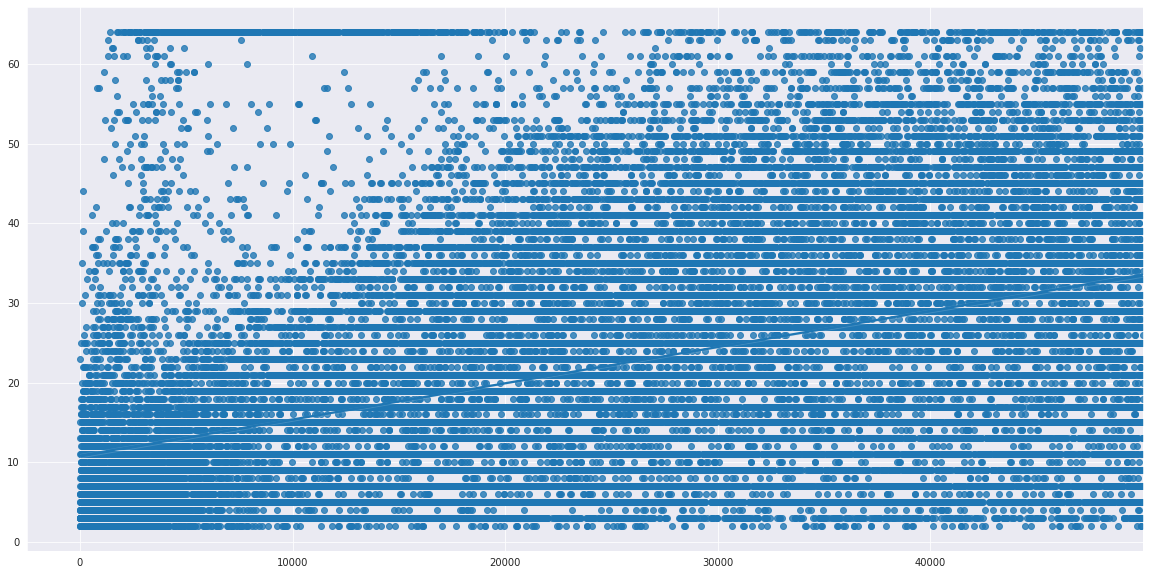

In [6]:
plt.figure(figsize = (20, 10))
sns.regplot(np.arange(len(ep_lens)), ep_lens)

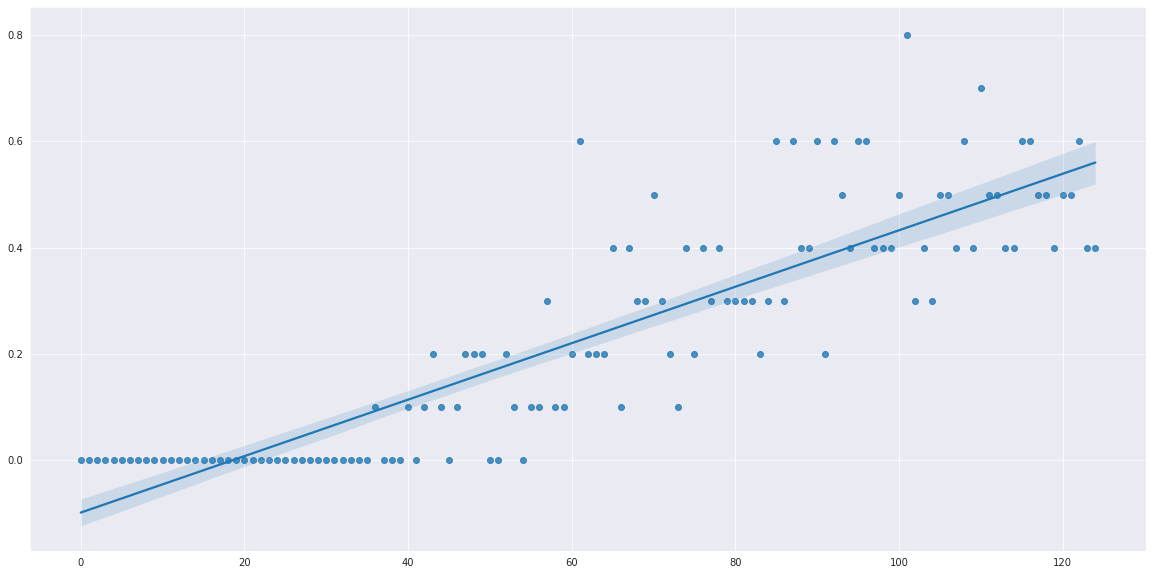

In [7]:
plt.figure(figsize = (20, 10))
ax = sns.regplot(x = np.arange(len(rates)), y = rates)

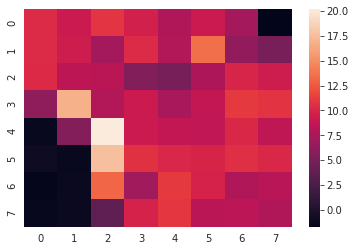

In [8]:
board1 = np.array([
    [-1, -1, -1, -1, -1, -1, -1,  3], # Second-last cell: mine. Last cell : repeat
    [-1, -1, -1, -1, -1, -1, -1, -1], # Last five cells; mines
    [-1, -1, -1, -1,  8, -1, -1, -1], # Fourth: mine. Fifth: repeat. Sixth: mine
    [-1, -1, -1, -1, -1, -1, -1, -1], # First two cells: not mines. Fourth, fifth, sixth: mines
    [ 1, -1, -1, -1, -1, -1, -1, -1], # First cell: repeat. Second cell: mine. Third cell: safe
    [ 1,  1, -1, -1, -1, -1, -1, -1], # First two: repeat. Third: not mine
    [ 0,  1, -1, -1, -1, -1, -1, -1], # First two: repeat. Third: not mine
    [ 0,  1, -1, -1, -1, -1, -1, -1]  # First two: repeat. Third: mine
])

e = Minefield(8, 8, 10, **rewards)
e.last_obs = board1

sns.heatmap(model.predict(e.network_obs).reshape(8, 8))

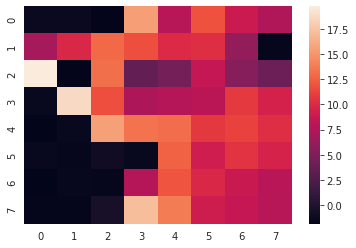

In [9]:
board2 = np.array([
    [ 1,  2,  1, -1, -1, -1, -1, -1], 
    [-1, -1, -1, -1, -1, -1, -1,  3], 
    [-1,  1, -1, -1, -1, -1, -1, -1], 
    [-1, -1, -1, -1, -1, -1, -1, -1], 
    [ 2, -1, -1, -1, -1, -1, -1, -1], 
    [ 1,  2, -1, 2, -1, -1, -1, -1],
    [ 0,  2,  2, -1, -1, -1, -1, -1], 
    [ 0,  1, -1, -1, -1, -1, -1, -1]
])
e.last_obs = board2

sns.heatmap(model.predict(e.network_obs).reshape(8,8))

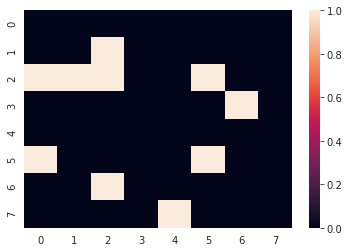

In [12]:
def play_single_game(model, env):
    env.prime()
    env.step((np.random.randint(env.n_rows), np.random.randint(env.n_cols)))
    
    states = []
    values = []
    
    while True:
        s = env.last_obs
        net_obs = env.network_obs
        
        Qs = model.predict(net_obs).reshape(8, 8)
        
        action = choose_action(model, net_obs)
        
        row = np.hstack([s, Qs, env.is_mine])
        states.append(s)
        values.append(Qs)
        
        _, _ , done, _ = env.step(action)
        if done:
            break
            
    return states, values

shows, vals = play_single_game(model, env)

sns.heatmap(env.is_mine)

In [13]:
len(shows) 

20

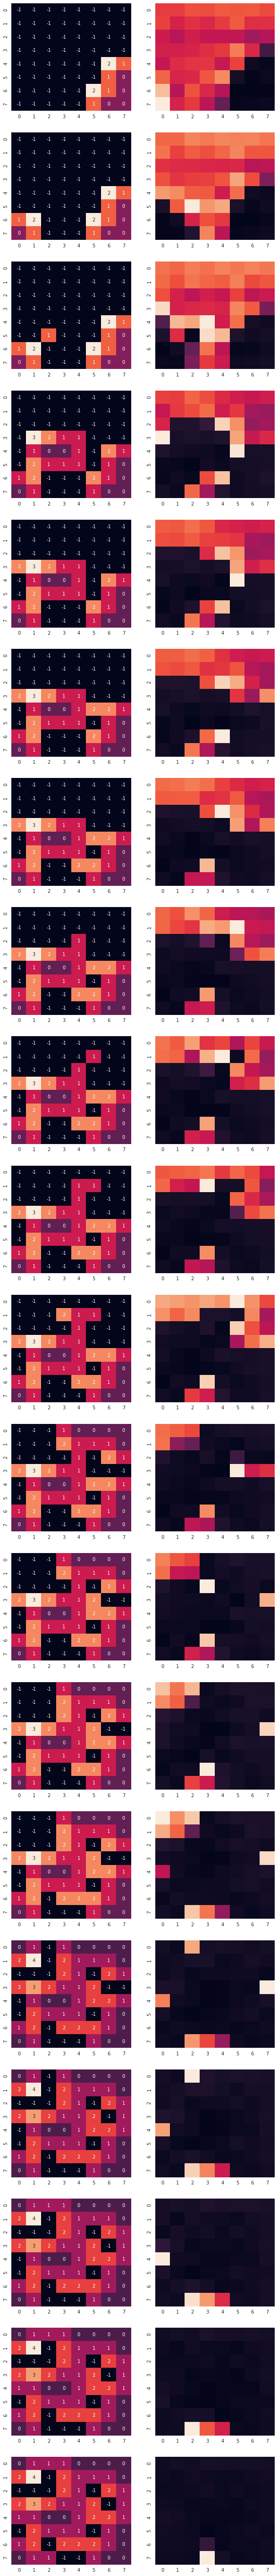

In [17]:
plt.figure(figsize = (10, 5 * len(shows)))

for i in range(len(shows)):
    l = plt.subplot(len(shows), 2, 2 * i + 1)
    r = plt.subplot(len(shows), 2, 2 * i + 2)
    
    sns.heatmap(shows[i], ax = l, annot = True, cbar = False)
    sns.heatmap(vals[i], ax = r, cbar = False)